# Validation of HMASR with snow depth stations
## Final figure

Update from v0: axwidth smaller, DJMFA -> DJF?, HMASR topo

- HMASR: [High Mountain Asia UCLA Daily Snow Reanalysis, Version 1](https://nsidc.org/data/HMA_SR_D)
- snow depth stations: [Observational snow depth dataset of the Tibetan Plateau (Version 1.0) (1961-2013)](https://data.tpdc.ac.cn/en/data/72d6dadf-8e1c-458b-b24e-91539042dfe6/)

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Load topography

In [2]:
latlim = slice(27, 45)
lonlim = slice(61, 105)

ds = xr.open_dataset('../data/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim, lon=lonlim)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

In [3]:
latlim = slice(27, 45)
lonlim = slice(61, 105)

# HMASR DEM
path_topo = '/home/lalandmi/Dropbox/data/elevation/' # local
hmasr_topo = xr.open_mfdataset(path_topo+'HMASR_DEM_DATA/*.nc', combine='by_coords').elevation \
        .rename({'Longitude': 'lon', 'Latitude': 'lat'}).transpose("lat", "lon").load()

## Load stations

In [47]:
path = '../data/in-situ_SD_TP_v1.0_1961-2013/'

df_loc = pd.read_csv(path+'Tibetan_Plateau_Snow_Depth_1961-2013.txt', delimiter='\t')
df_loc.set_index('numb', inplace=True)
df_loc['hmasr_topo'] = [hmasr_topo.sel(lat=df_loc.iloc[i].latit, lon=df_loc.iloc[i].longit, method='nearest').values.item(0) for i in range(df_loc.index.size)]
df_loc

,prov,name_en,name_cn,latit,longit,elevat,hmasr_topo
numb,,,,,,,
52787,甘肃,S52787,乌鞘岭,37.2,102.9,3045.1,3053.8
52978,甘肃,S52978,夏河,35.2,102.5,2929.4,2934.8
56071,甘肃,S56071,碌曲,34.6,102.5,3105.7,3105.9
56074,甘肃,S56074,玛曲,34.0,102.1,3471.4,3477.0
56080,甘肃,S56080,合作,35.0,102.9,2910.0,2925.6
...,...,...,...,...,...,...,...
56434,西藏,S56434,察隅,28.6,97.5,2327.6,2793.7
56444,云南,S56444,德钦,28.5,98.9,3319.0,3221.5
56533,云南,S56533,贡山,27.8,98.7,1583.3,1552.4


## Load timseries data 
Saved in `HMASR_validation_with_TPDC_SD_stations.ipynb`

In [5]:
df_station_HMASR = pd.read_csv('data/HMASR_validation_with_TPDC_SD_stations.csv', header=[0, 1], index_col=0, parse_dates=True)
df_station_HMASR = df_station_HMASR.where(df_station_HMASR >= 0) # to avoid some negative values
df_station_HMASR

numb         52787         52978         56071         56074         56080  \
product    station HMASR station HMASR station HMASR station HMASR station   
date                                                                         
1999-10-01     NaN  0.00     0.0  0.04     0.0  0.18     0.0  0.26     0.0   
1999-10-02     4.0  0.00     0.0  0.04     0.0  0.34     0.0  0.46     0.0   
1999-10-03     0.0  0.06     0.0  0.28     0.0  0.52     0.0  0.52     0.0   
1999-10-04     2.0  0.00     0.0  0.24     0.0  0.78     0.0  1.18     0.0   
1999-10-05     0.0  0.00     0.0  0.10     0.0  0.54     0.0  1.86     0.0   
...            ...   ...     ...   ...     ...   ...     ...   ...     ...   
2013-12-27     0.0  0.82     0.0  2.20     0.0  0.00     0.0  0.04     0.0   
2013-12-28     0.0  0.82     0.0  2.18     0.0  0.00     0.0  0.04     0.0   
2013-12-29     0.0  0.80     0.0  2.16     0.0  0.00     0.0  0.04     0.0   
2013-12-30     0.0  0.78     0.0  2.10     0.0  0.00     0.0  0.04     0.0   
2013-12-31     0.0  0.78     0.0  2.04     0.0  0.00     0.0  0.04     0.0   

numb              ...   56434         56444         56533         56543        \
product    HMASR  ... station HMASR station HMASR station HMASR station HMASR   
date              ...                                                           
1999-10-01   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-02   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-03   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-04   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-05   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
...          ...  ...     ...   ...     ...   ...     ...   ...     ...   ...   
2013-12-27   0.0  ...     0.0  5.88     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-28   0.0  ...     0.0  6.50     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-29   0.0  ...     0.0  8.70     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-30   0.0  ...     0.0  7.42     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-31   0.0  ...     0.0  5.84     0.0   0.0     0.0   0.0     0.0   0.0   

numb         56641        
product    station HMASR  
date                      
1999-10-01     NaN   NaN  
1999-10-02     NaN   NaN  
1999-10-03     NaN   NaN  
1999-10-04     NaN   NaN  
1999-10-05     NaN   NaN  
...            ...   ...  
2013-12-27     NaN   NaN  
2013-12-28     NaN   NaN  
2013-12-29     NaN   NaN  
2013-12-30     NaN   NaN  
2013-12-31     NaN   NaN  

[5206 rows x 204 columns]

### Get >90% time coverage and >1mm in DJFMA
We are going to make some criteria for taking stations, as many stations doesn't have much snow, so for example we can take stations that have a minimum of snow in winter (ex: 1mm threshold) + taking only stations that have more than 90% of data for example.

In [6]:
# Remove stations with less than 90% of data
df_station_HMASR_90 = df_station_HMASR.dropna(thresh=df_station_HMASR.index.size*0.9, axis=1)

temp = df_station_HMASR_90.xs('station', axis=1, level='product').resample('m').mean()
winter_mask = ((temp.index.month > 11) | (temp.index.month < 5))

# Take stations having at least 1mm of snow in winter (DJFMA)
mm_mask = temp[winter_mask].mean() > 0.1

# Index of the 62 corresponding stations (> 1mm in winter)
index_1mm = mm_mask[mm_mask == True].index

df_station_HMASR_90_1mm = df_station_HMASR_90[index_1mm]
df_station_HMASR_90_1mm

numb         52787         52978         56071         56074         56080  \
product    station HMASR station HMASR station HMASR station HMASR station   
date                                                                         
1999-10-01     NaN  0.00     0.0  0.04     0.0  0.18     0.0  0.26     0.0   
1999-10-02     4.0  0.00     0.0  0.04     0.0  0.34     0.0  0.46     0.0   
1999-10-03     0.0  0.06     0.0  0.28     0.0  0.52     0.0  0.52     0.0   
1999-10-04     2.0  0.00     0.0  0.24     0.0  0.78     0.0  1.18     0.0   
1999-10-05     0.0  0.00     0.0  0.10     0.0  0.54     0.0  1.86     0.0   
...            ...   ...     ...   ...     ...   ...     ...   ...     ...   
2013-12-27     0.0  0.82     0.0  2.20     0.0  0.00     0.0  0.04     0.0   
2013-12-28     0.0  0.82     0.0  2.18     0.0  0.00     0.0  0.04     0.0   
2013-12-29     0.0  0.80     0.0  2.16     0.0  0.00     0.0  0.04     0.0   
2013-12-30     0.0  0.78     0.0  2.10     0.0  0.00     0.0  0.04     0.0   
2013-12-31     0.0  0.78     0.0  2.04     0.0  0.00     0.0  0.04     0.0   

numb              ...   56223         56434         56444         56533        \
product    HMASR  ... station HMASR station HMASR station HMASR station HMASR   
date              ...                                                           
1999-10-01   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-02   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-03   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-04   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-05   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
...          ...  ...     ...   ...     ...   ...     ...   ...     ...   ...   
2013-12-27   0.0  ...     0.0  0.30     0.0  5.88     0.0   0.0     0.0   0.0   
2013-12-28   0.0  ...     0.0  0.28     0.0  6.50     0.0   0.0     0.0   0.0   
2013-12-29   0.0  ...     0.0  0.30     0.0  8.70     0.0   0.0     0.0   0.0   
2013-12-30   0.0  ...     0.0  0.30     0.0  7.42     0.0   0.0     0.0   0.0   
2013-12-31   0.0  ...     0.0  0.30     0.0  5.84     0.0   0.0     0.0   0.0   

numb         56543        
product    station HMASR  
date                      
1999-10-01     0.0   0.0  
1999-10-02     0.0   0.0  
1999-10-03     0.0   0.0  
1999-10-04     0.0   0.0  
1999-10-05     0.0   0.0  
...            ...   ...  
2013-12-27     0.0   0.0  
2013-12-28     0.0   0.0  
2013-12-29     0.0   0.0  
2013-12-30     0.0   0.0  
2013-12-31     0.0   0.0  

[5206 rows x 124 columns]

In [72]:
pd.set_option('display.max_rows', None)
df_loc[['latit', 'longit', 'elevat', 'hmasr_topo']].loc[index_1mm.to_numpy().astype(np.int)]

,latit,longit,elevat,hmasr_topo
numb,,,,
52787,37.2,102.9,3045.1,3053.8
52978,35.2,102.5,2929.4,2934.8
56071,34.6,102.5,3105.7,3105.9
56074,34.0,102.1,3471.4,3477.0
56080,35.0,102.9,2910.0,2925.6
56081,34.7,103.3,2810.2,2789.7
56082,34.6,103.5,2540.3,2632.0
56084,34.1,103.2,2374.2,2599.2
52836,36.3,98.1,3189.0,3188.4


## Check different zones

In [7]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

def plot_zones(ax):
#     lonlim_ITP, latlim_ITP, lonlim_HM, latlim_HM, lonlim_ETP, latlim_ETP = \
#         get_zones()

    # HKK
    ax.text(lonlim_ITP.start + 0.5, latlim_ITP.stop - 2, 'ITP', zorder=10)
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lonlim_ITP.start, latlim_ITP.start],
            width=lonlim_ITP.stop - lonlim_ITP.start,
            height=latlim_ITP.stop - latlim_ITP.start,
            transform=ccrs.PlateCarree(),
            fill=False,
            zorder=10
        )
    )

    # HM
    ax.text(lonlim_HM.start + 0.5, latlim_HM.stop - 2, 'HM', zorder=10)
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lonlim_HM.start, latlim_HM.start],
            width=lonlim_HM.stop - lonlim_HM.start,
            height=latlim_HM.stop - latlim_HM.start,
            transform=ccrs.PlateCarree(),
            fill=False,
            zorder=10
        )
    )

    # TP
    ax.text(lonlim_ETP.start + 0.5, latlim_ETP.stop - 2, 'ETP', zorder=10)
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lonlim_ETP.start, latlim_ETP.start],
            width=lonlim_ETP.stop - lonlim_ETP.start,
            height=latlim_ETP.stop - latlim_ETP.start,
            transform=ccrs.PlateCarree(),
            fill=False,
            zorder=10
        )
    )

    return None

In [8]:
u.get_zones()

(slice(68, 96, None),
 slice(40, 45, None),
 slice(68, 80, None),
 slice(31, 40, None),
 slice(80, 105, None),
 slice(31, 40, None),
 slice(77, 104, None),
 slice(26, 31, None))

In [9]:
# Get zone limits for annual cycle
# lonlim_ITP, latlim_ITP, lonlim_HM, latlim_HM, lonlim_ETP, latlim_ETP = u.get_zones()
lonlim_ITP, latlim_ITP, lonlim_HM, latlim_HM, lonlim_ETP, latlim_ETP = (slice(79, 99, None),
 slice(31, 38, None),
 slice(79, 104, None),
 slice(26, 31, None),
 slice(99, 104, None),
 slice(31, 38, None))

In [10]:
index_ITP = []
index_HM = []
index_ETP = []

for index in index_1mm:
    if (df_loc.loc[[int(index)]].latit.values > latlim_ITP.start) & (df_loc.loc[[int(index)]].latit.values < latlim_ITP.stop) & \
        (df_loc.loc[[int(index)]].longit.values > lonlim_ITP.start) & (df_loc.loc[[int(index)]].longit.values < lonlim_ITP.stop):
        index_ITP.append(index)
    elif (df_loc.loc[[int(index)]].latit.values > latlim_HM.start) & (df_loc.loc[[int(index)]].latit.values < latlim_HM.stop) & \
        (df_loc.loc[[int(index)]].longit.values > lonlim_HM.start) & (df_loc.loc[[int(index)]].longit.values < lonlim_HM.stop):
        index_HM.append(index)
    elif (df_loc.loc[[int(index)]].latit.values > latlim_ETP.start) & (df_loc.loc[[int(index)]].latit.values < latlim_ETP.stop) & \
        (df_loc.loc[[int(index)]].longit.values > lonlim_ETP.start) & (df_loc.loc[[int(index)]].longit.values < lonlim_ETP.stop):
        index_ETP.append(index)

list_index = [index_1mm, index_ITP, index_ETP, index_HM]
zones = ['All', 'ITP', 'ETP', 'HM']

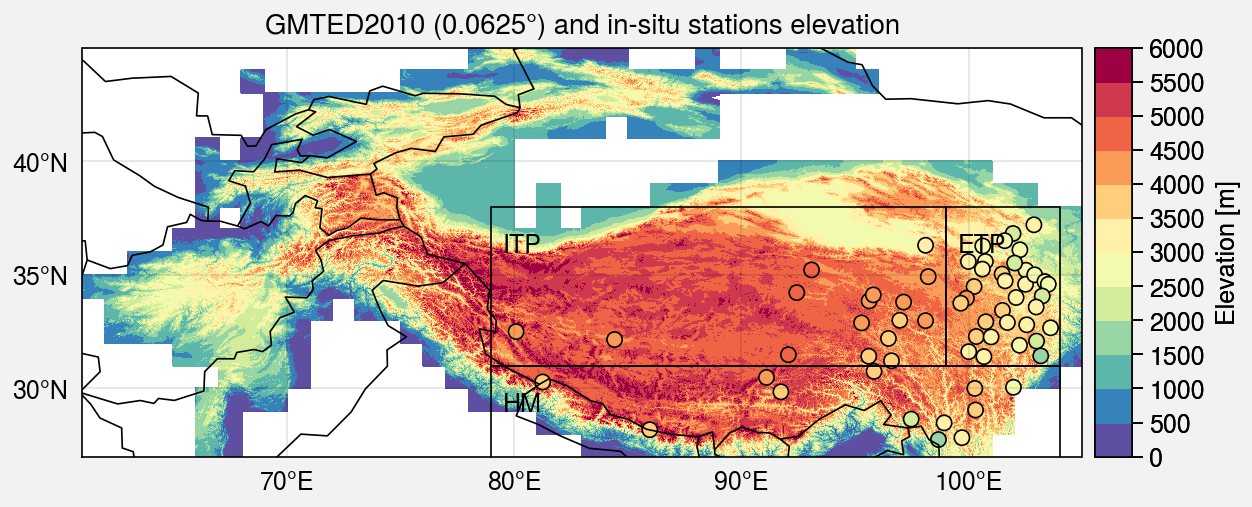

In [12]:
cmap='Spectral_r'
levels=plot.arange(0,6000,500)
markersize=30
pd.set_option("display.precision", 1)

fig, axs = plot.subplots(proj='cyl', axwidth=5, share=0)

# Plot topography (HMA + zoom)
axs[0].pcolormesh(hmasr_topo, colorbar='r', cmap=cmap, levels=levels, colorbar_kw={'label': 'Elevation [m]'})
axs[0].scatter(
    df_loc.loc[index_1mm.to_numpy().astype(np.int)].longit.values, 
    df_loc.loc[index_1mm.to_numpy().astype(np.int)].latit.values, 
    markersize=markersize, marker='o', color=df_loc.loc[index_1mm.to_numpy().astype(np.int)].elevat.values, 
    cmap=cmap, edgecolors='black', levels=levels
)

axs[0].format(
    borders=True, labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
)


titles = [
    'HMASR and in-situ stations elevation',
]
for i, ax in enumerate(axs):
    ax.format(title=titles[i]) 
    if i == 0: plot_zones(ax)

# fig.save('img/comparison_HMASR_station_averaged_90_1mm_elevation_zones.jpg')

## Get monthly spatial SD (at 5km)

In [13]:
# Sélectionner toutes les années 1999-10-01 à 2013-12-31 pour faire correspondre aux stations
# Montly averaged data (so the timestamp is at the end of the month -> 1999-10-31 = mean(1999-10-01 to 1999-10-31))

# path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_M/WY1999_00/'
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_M_combined/'

In [14]:
# mount_summer
ds = xr.open_mfdataset(path+'/*SD*', parallel=True)
ds

<xarray.Dataset>
Dimensions:  (lat: 450, lon: 1100, time: 216)
Coordinates:
  * lat      (lat) float64 27.02 27.06 27.1 27.14 ... 44.86 44.9 44.94 44.98
  * lon      (lon) float64 61.02 61.06 61.1 61.14 ... 104.9 104.9 104.9 105.0
  * time     (time) datetime64[ns] 1999-10-31 1999-11-30 ... 2017-09-30
Data variables:
    SD_Post  (time, lat, lon) float32 dask.array<chunksize=(12, 450, 1100), meta=np.ndarray>

In [15]:
# Define common period
period = slice('1999-10-01','2013-12-31')
sd = ds.sel(time=period).SD_Post.load()*100 # convert m to cm

In [16]:
# sd_annual = ds.SD_Post.mean('time').compute()*100
# sd_winter = ds.SD_Post.where( (ds['time.month'] == 12) | (ds['time.month'] < 5) ).mean('time').compute()*100 # DJFMA
# sd_summer = ds.SD_Post.where( (ds['time.month'] > 5 ) & (ds['time.month'] < 10) ).mean('time').compute()*100 # JJAS

In [17]:
sd_annual = sd.mean('time')
sd_winter = sd.where( (ds['time.month'] == 12) | (ds['time.month'] < 5) ).mean('time') # DJFMA
sd_summer = sd.where( (ds['time.month'] > 5 ) & (ds['time.month'] < 10) ).mean('time') # JJAS

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Plot

In [23]:
# Resample station by month and apply mask for seasons
temp = df_station_HMASR_90_1mm.xs('station', axis=1, level='product').resample('m').mean()
winter_mask = ((temp.index.month > 11) | (temp.index.month < 5))
summer_mask = ((temp.index.month > 5) & (temp.index.month < 10))

# Take stations having at least 1mm of snow in winter (DJFMA)
df_annual = temp.mean()
df_winter = temp[winter_mask].mean()
df_summer = temp[summer_mask].mean()

In [76]:
# Resample station by month and apply mask for seasons
temp = df_station_HMASR_90_1mm.xs('HMASR', axis=1, level='product').resample('m').mean()
winter_mask = ((temp.index.month > 11) | (temp.index.month < 5))
summer_mask = ((temp.index.month > 5) & (temp.index.month < 10))

# Take stations having at least 1mm of snow in winter (DJFMA)
df_HMASR_annual = temp.mean()
df_HMASR_winter = temp[winter_mask].mean()
df_HMASR_summer = temp[summer_mask].mean()

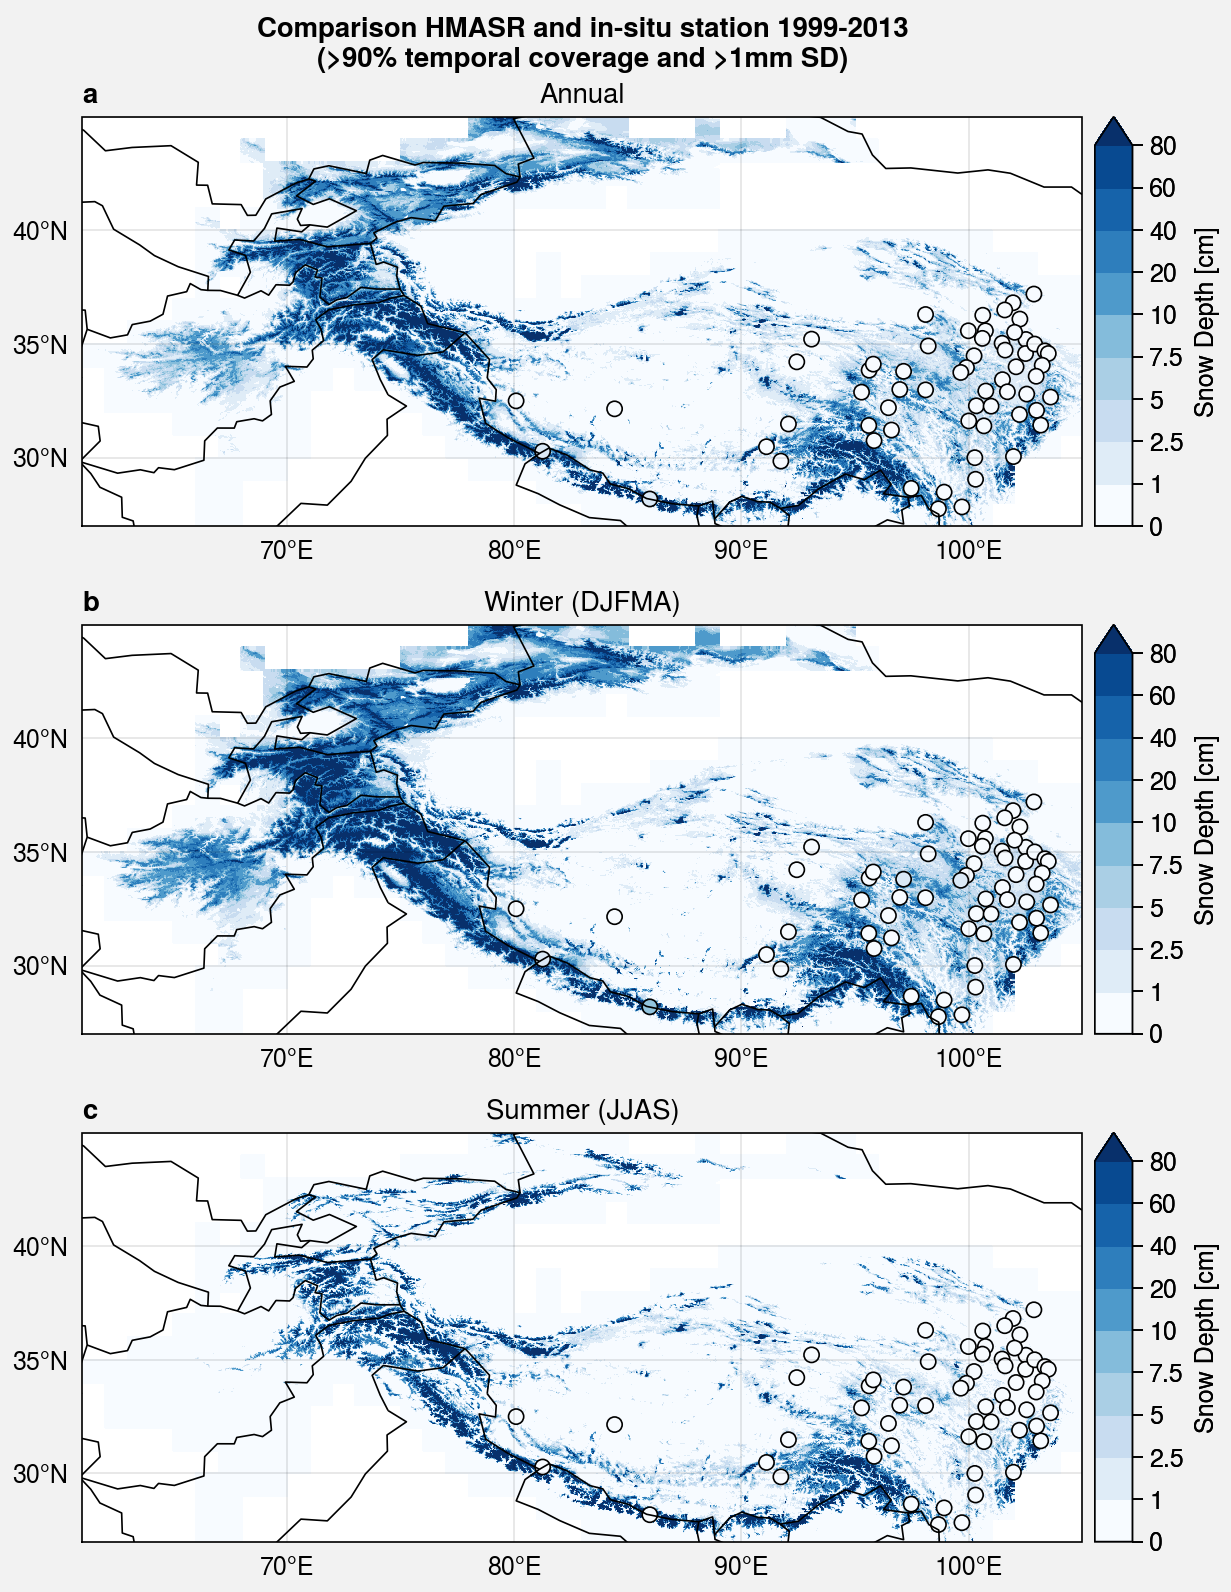

In [24]:
cmap='Blues'
# levels=plot.arange(0,100,10)
levels=[0, 1, 2.5, 5, 7.5, 10, 20, 40, 60, 80]
extend='max'
markersize=30
pd.set_option("display.precision", 1)

fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5, share=0)

# Plot topography (HMA + zoom)

df_list = [df_annual, df_winter, df_summer]
sd_list = [sd_annual, sd_winter, sd_summer]

for i, ax in enumerate(axs):
    ax.pcolormesh(sd_list[i], colorbar='r', cmap=cmap, levels=levels, extend=extend, colorbar_kw={'label': 'Snow Depth [cm]'})
    ax.scatter(
        df_loc.loc[index_1mm.to_numpy().astype(np.int)].longit.values, 
        df_loc.loc[index_1mm.to_numpy().astype(np.int)].latit.values, 
        markersize=markersize, marker='o', color=df_list[i], 
        cmap=cmap, edgecolors='black', levels=levels
    )

    
# Format   
axs.format(
    suptitle='Comparison HMASR and in-situ station 1999-2013\n(>90% temporal coverage and >1mm SD)',
    abc=True,
    borders=True, labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
)


titles = [
    'Annual',
    'Winter (DJFMA)',
    'Summer (JJAS)'
]
for i, ax in enumerate(axs):
    ax.format(title=titles[i])

# fig.save('img/spatial_SD_comparison_HMASR_station_averaged_90_1mm.jpg')

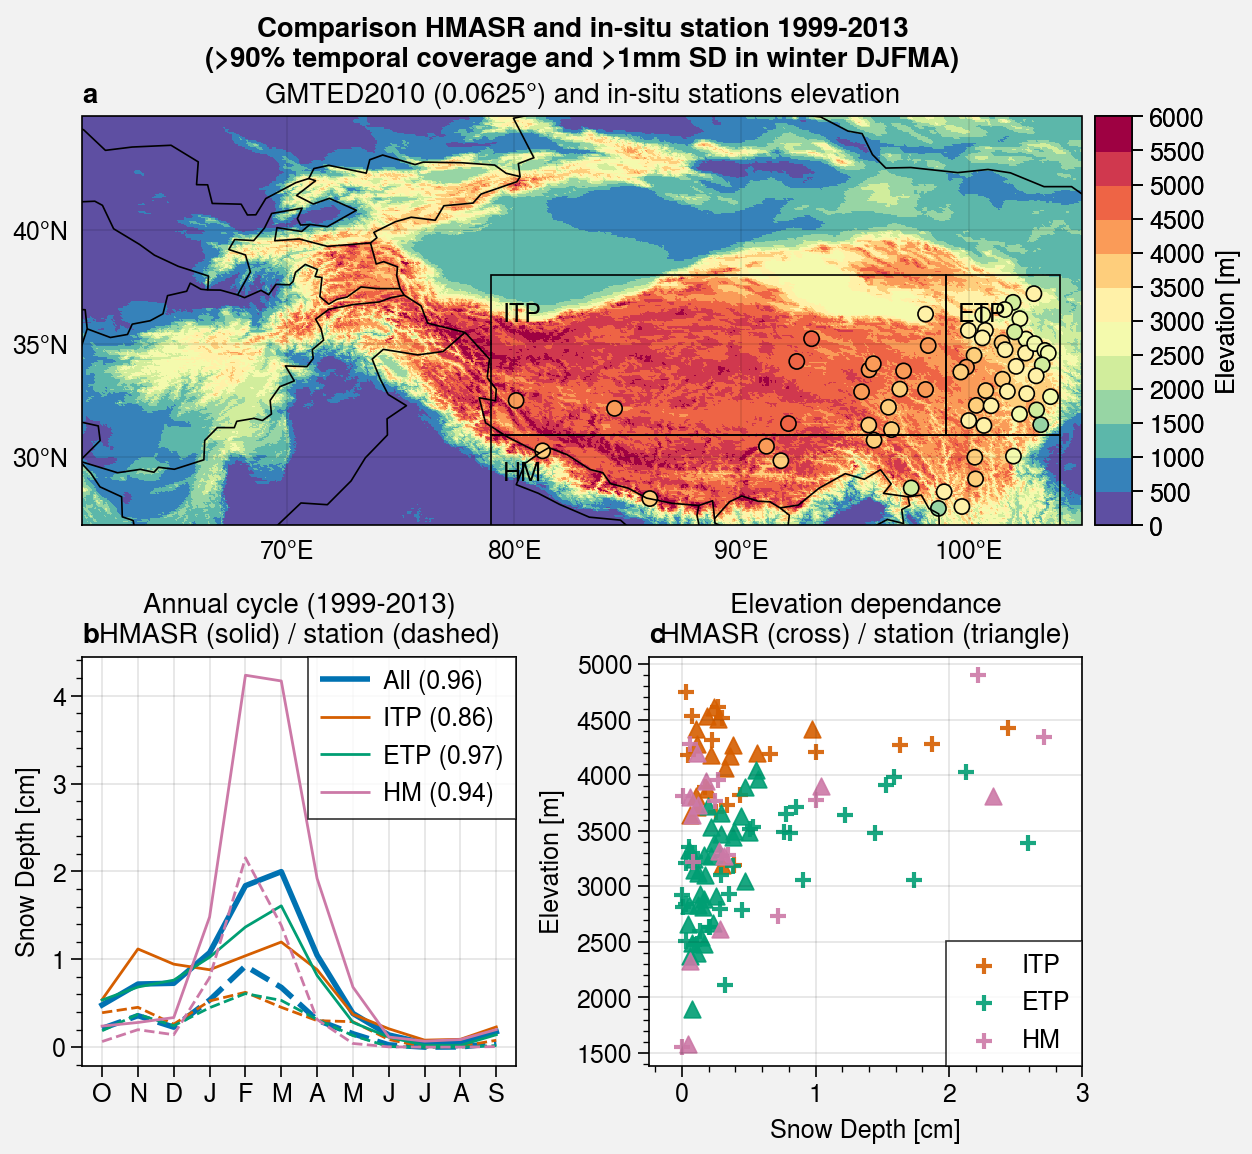

In [48]:
cmap='Spectral_r'
levels=plot.arange(0,6000,500)
markersize=30

fig, axs = plot.subplots([[1, 1], [2, 3]], proj=('cyl', None, None), axwidth=5, share=0)

##################
### Topography ###
##################
axs[0].pcolormesh(elevation, colorbar='r', cmap=cmap, levels=levels, colorbar_kw={'label': 'Elevation [m]'})
axs[0].scatter(
    df_loc.loc[index_1mm.to_numpy().astype(np.int)].longit.values, 
    df_loc.loc[index_1mm.to_numpy().astype(np.int)].latit.values, 
    markersize=markersize, marker='o', color=df_loc.loc[index_1mm.to_numpy().astype(np.int)].elevat.values, 
    cmap=cmap, edgecolors='black', levels=levels
)

axs[0].format(
    borders=True, labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
)

####################
### Annual cycle ###
####################
hs = []
for i, zone in enumerate(zones):
    if i == 0:
        lindewidth = 2
    else:
        lindewidth = 1
        
    ac = df_station_HMASR_90_1mm[list_index[i]].mean(level='product', axis=1).groupby(df_station_HMASR_90_1mm[list_index[i]].index.month).mean()
    
    # Compute correlation
    r = stats.pearsonr(ac.station.values, ac.HMASR.values)[0]
    
    h1 = axs[1].plot(ac.reindex(index=np.roll(ac.index,3)).station.values, label=zone, color='C'+str(i), linestyle='--', linewidth=lindewidth)
    h2 = axs[1].plot(ac.reindex(index=np.roll(ac.index,3)).HMASR.values, label=zone+' ({:.2})'.format(r), color='C'+str(i), linewidth=lindewidth)
    
    hs.append(h2[0])

axs[1].format(
    xlocator='index', xformatter=['O','N','D', 'J','F','M','A','M','J','J','A','S'], xtickminor=False, 
    xlabel='', ylabel='Snow Depth [cm]'
)

axs[1].legend(hs, ncol=1)


#######################
### Elevation vs SD ###
#######################

hs = []
for i, zone in enumerate(zones[1:]):
    # HMASR
    x = df_station_HMASR_90_1mm[list_index[i+1]].xs('HMASR', level='product', axis=1).mean().values
    y = df_loc.loc[np.asarray(list_index[i+1], dtype='int')].hmasr_topo.values
    h1 = axs[2].scatter(x, y, alpha=0.9, marker='+', label=zone, color='C'+str(i+1))

    # station
    x = df_station_HMASR_90_1mm[list_index[i+1]].xs('station', level='product', axis=1).mean().values
    y = df_loc.loc[np.asarray(list_index[i+1], dtype='int')].elevat.values
    axs[2].scatter(x, y, alpha=0.9, marker='^', label=zone, color='C'+str(i+1))
    
    hs.append(h1)

axs[2].legend(hs, ncol=1, loc='lr')

axs[2].format(
    xlabel='Snow Depth [cm]',
    ylabel='Elevation [m]',
    xlim=(-0.25,3),
)


##############
### Format ###
##############
axs.format(
    suptitle='Comparison HMASR and in-situ station 1999-2013\n(>90% temporal coverage and >1mm SD in winter DJFMA)',
    abc=True
)

titles = [
    'GMTED2010 (0.0625°) and in-situ stations elevation',
    'Annual cycle (1999-2013)\nHMASR (solid) / station (dashed)',
    'Elevation dependance\nHMASR (cross) / station (triangle)',
]
for i, ax in enumerate(axs):
    ax.format(title=titles[i]) 
    if i == 0: plot_zones(ax)

# fig.save('img/comparison_HMASR_station_averaged_90_1mm_elevation_zones_ac_elevation_SD.jpg')

## Final figure

In [103]:
df_HMASR_annual.max()

5.837205001799302

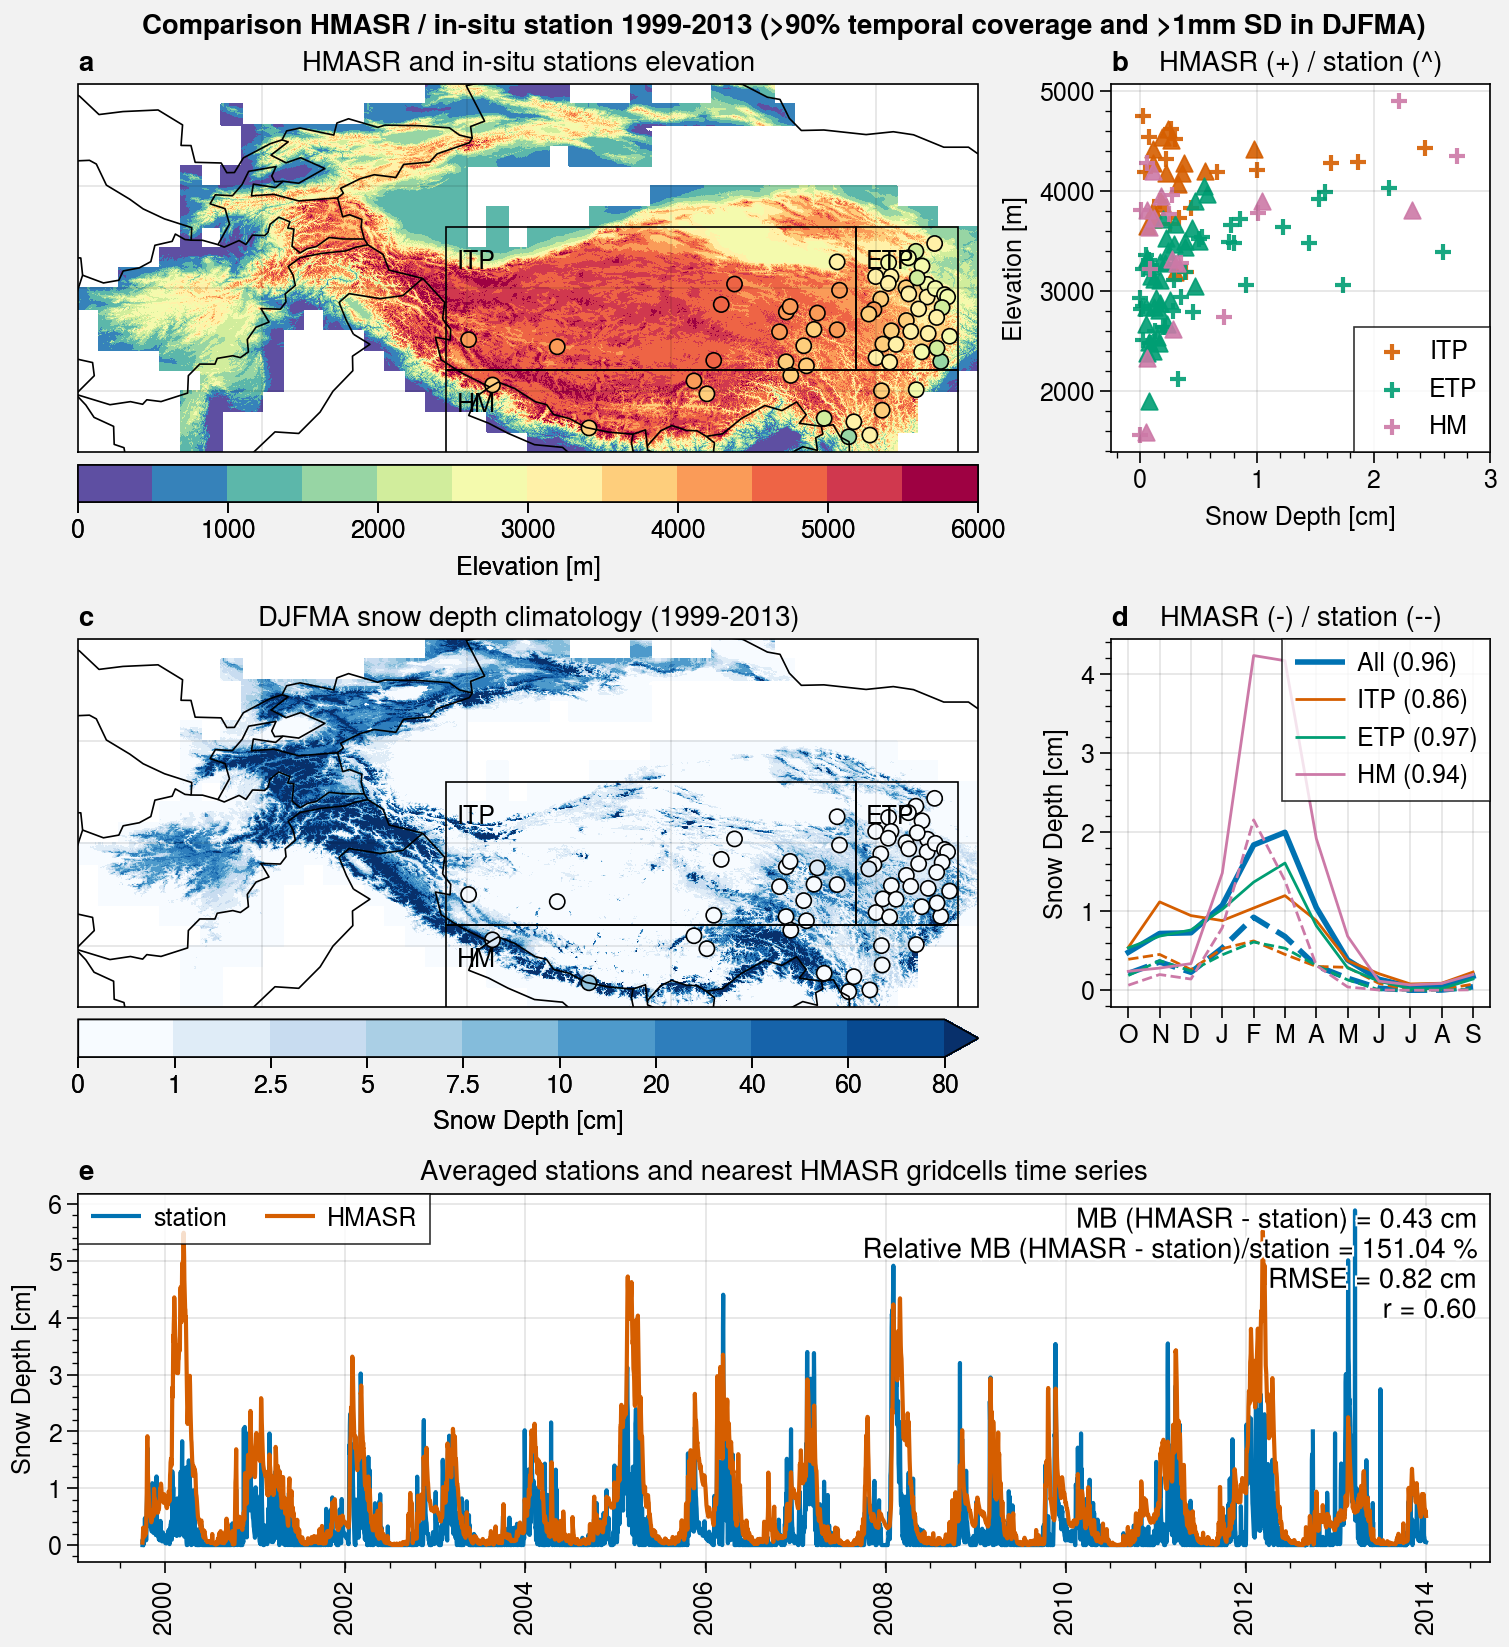

In [108]:
markersize=30

fig, axs = plot.subplots([[1, 1, 2], [3, 3, 4], [5, 5, 5]], proj=('cyl', None, 'cyl',  None, None), axwidth=4.5, share=0)

##################
### Topography ###
##################
cmap='Spectral_r'
levels=plot.arange(0,6000,500)
ax = axs[0]
m = ax.pcolormesh(hmasr_topo, cmap=cmap, levels=levels)
ax.scatter(
    df_loc.loc[index_1mm.to_numpy().astype(np.int)].longit.values, 
    df_loc.loc[index_1mm.to_numpy().astype(np.int)].latit.values, 
    markersize=markersize, marker='o', color=df_loc.loc[index_1mm.to_numpy().astype(np.int)].elevat.values, 
    cmap=cmap, edgecolors='black', levels=levels
)

ax.colorbar(m, label='Elevation [m]', loc='b')

ax.format(
    borders=True, labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    title='HMASR and in-situ stations elevation'
)
plot_zones(ax)


#######################
### Elevation vs SD ###
#######################
ax = axs[1]
hs = []
for i, zone in enumerate(zones[1:]):
    # HMASR
    x = df_station_HMASR_90_1mm[list_index[i+1]].xs('HMASR', level='product', axis=1).mean().values
    y = df_loc.loc[np.asarray(list_index[i+1], dtype='int')].hmasr_topo.values
    h1 = ax.scatter(x, y, alpha=0.9, marker='+', label=zone, color='C'+str(i+1))

    # station
    x = df_station_HMASR_90_1mm[list_index[i+1]].xs('station', level='product', axis=1).mean().values
    y = df_loc.loc[np.asarray(list_index[i+1], dtype='int')].elevat.values
    ax.scatter(x, y, alpha=0.9, marker='^', label=zone, color='C'+str(i+1))
    
    hs.append(h1)

ax.legend(hs, ncol=1, loc='lr')

ax.format(
    xlabel='Snow Depth [cm]',
    ylabel='Elevation [m]',
    xlim=(-0.25,3),
    title='HMASR (+) / station (^)'
)


##################
### Snow depth ###
##################
ax = axs[2]
cmap='Blues'
levels=[0, 1, 2.5, 5, 7.5, 10, 20, 40, 60, 80]
extend='max'

m = ax.pcolormesh(sd_winter,cmap=cmap, levels=levels, extend=extend)
ax.scatter(
    df_loc.loc[index_1mm.to_numpy().astype(np.int)].longit.values, 
    df_loc.loc[index_1mm.to_numpy().astype(np.int)].latit.values, 
    markersize=markersize, marker='o', color=df_winter, 
    cmap=cmap, edgecolors='black', levels=levels
)

ax.colorbar(m, label='Snow Depth [cm]', loc='b')

ax.format(
    borders=True, labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    title='DJFMA snow depth climatology (1999-2013)'
)
plot_zones(ax)


####################
### Annual cycle ###
####################
ax = axs[3]
hs = []
for i, zone in enumerate(zones):
    if i == 0:
        lindewidth = 2
    else:
        lindewidth = 1
        
    ac = df_station_HMASR_90_1mm[list_index[i]].mean(level='product', axis=1).groupby(df_station_HMASR_90_1mm[list_index[i]].index.month).mean()
    
    # Compute correlation
    r = stats.pearsonr(ac.station.values, ac.HMASR.values)[0]
    
    h1 = ax.plot(ac.reindex(index=np.roll(ac.index,3)).station.values, label=zone, color='C'+str(i), linestyle='--', linewidth=lindewidth)
    h2 = ax.plot(ac.reindex(index=np.roll(ac.index,3)).HMASR.values, label=zone+' ({:.2})'.format(r), color='C'+str(i), linewidth=lindewidth)
    
    hs.append(h2[0])

ax.format(
    xlocator='index', xformatter=['O','N','D', 'J','F','M','A','M','J','J','A','S'], xtickminor=False, 
    xlabel='', ylabel='Snow Depth [cm]',
    title='HMASR (-) / station (--)'
)

ax.legend(hs, ncol=1)
    

###################
### Time series ###
###################
ax = axs[4]
ts = df_station_HMASR_90_1mm.mean(level='product', axis=1)

# Compute metrics
mb = (ts.dropna().mean().HMASR - ts.dropna().mean().station)
rmb = (ts.dropna().mean().HMASR - ts.dropna().mean().station)/ts.dropna().mean().station*100
rmse = np.sqrt(((ts.dropna().HMASR - ts.dropna().station)**2).mean())
corr, _ = stats.pearsonr(ts.dropna().HMASR, ts.dropna().station)
    
# Time series
hs = ax.plot(ts)
ax.format(
    ylabel='Snow Depth [cm]',
    urtitle='MB (HMASR - station) = {:.2f}'.format(mb)+' cm\n'+ \
            'Relative MB (HMASR - station)/station = {:.2f}'.format(rmb)+' %\n'+ \
            'RMSE = {:.2f}'.format(rmse)+' cm\n'+ \
            'r = {:.2f}'.format(corr),
    title='Averaged stations and nearest HMASR gridcells time series'
)
ax.legend(hs, loc='ul')

    
##############
### Format ###
############## 
axs.format(
    suptitle='Comparison HMASR / in-situ station 1999-2013 (>90% temporal coverage and >1mm SD in DJFMA)',
    abc=True
)

fig.save('img/fig_HMASR_station_90_1mm_v1.jpg')